# Study photon-detection and stochastic fluctuations close to the phase transition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import random


import matplotlib.gridspec as gridspec

from scipy.linalg import logm

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), mode='same') /w


np.set_printoptions(suppress=True)


# Define PPK model
​
Hamiltonian is 
\begin{equation}
H = G( a^{2} + a^{\dagger 2}) + \frac{U}{2} a^{\dagger 2} a^{2} - \Delta a^{\dagger}a
\end{equation}
​
Master equation for this is 
\begin{equation}
\frac{d \rho}{dt} = - i[H, \rho] + \kappa \mathcal{D}[a]\rho
\end{equation}
 
Study under Homodyne detection first, since we saw divergence near the steadystate

Use parity operator defined as
\begin{equation}
P = \sum_{i=0}^{n} (-1)^{n} |n\rangle \langle n |
\end{equation}

Study the parity operator as a function of detuning and n

In [2]:
def Parity(N):
    
    p = fock_dm(N, 0)
    for i in range(1, N):
        p += (-1)**(i) * fock_dm(N, i)
        
    return(p)

# Study Homodyne for large and small N

First compute of $\Delta$ where the phase transition occurs
\begin{equation}
\Delta > \sqrt{G^{2} - \frac{\kappa^{2}}{4}}
\end{equation}

In [125]:
# Define parameters

na = 2
G = 1
U = 1/na
κ =  1
ϵ = 0*np.sqrt(na)
Δ = 2.2

print(2*np.sqrt(G**2 - κ**2/4))

1.7320508075688772


In [126]:
N = 30
a = destroy(N)
n = num(N)
x = (a + a.dag())/np.sqrt(2)
p = -1j*(a - a.dag())/np.sqrt(2)
par = Parity(N)


H = (G/2) * (a**2 + a.dag()**2) + (U/2)*a.dag()**2 * a**2 + 1j*ϵ*(a - a.dag()) - Δ*a.dag()*a
c_ops = [np.sqrt(κ)*a]
rho0 = steadystate(H, c_ops)
# rho0 = fock_dm(N, 5)
psi0 = rho0.eigenstates()[1][-2]


print(expect(n, psi0))
print(variance(n, psi0))

6.222333920577869
3.3643406880518114


In [127]:
# Randomly select initial state
states = rho0.eigenstates()[1][-3:]
probs = rho0.eigenstates()[0][-3:]

probs

array([0.18543341, 0.18582702, 0.51728156])

In [128]:
# Define time parameters of the system
tm = 0
tM = 1000
ts = 100000
t = np.linspace(tm, tM, ts)
dt = 1/(ts - 1)

# Dictionary of observables
e_dict = {'n': n,
         'x': x,
         'p': p,
         'n2': n**2,
         'x2': x**2,
         'par': par
         }
# Specify observables
e_ops = list(e_dict.values())

In [129]:
sc_ops = [np.sqrt(κ)*a]
ntraj = 1   # Number of trajectories to average over
nsubsteps = 10

output = photocurrent_sesolve(H, psi0, t,   
                        sc_ops = c_ops,
                        ntraj=ntraj, 
                        e_ops = e_ops,
                        nsubsteps=nsubsteps, 
                        store_measurement=True
                     )

# Create dictionary of observables
e_t = {key: out for key, out in zip(e_dict, output.expect)}

Total run time:   5.71s


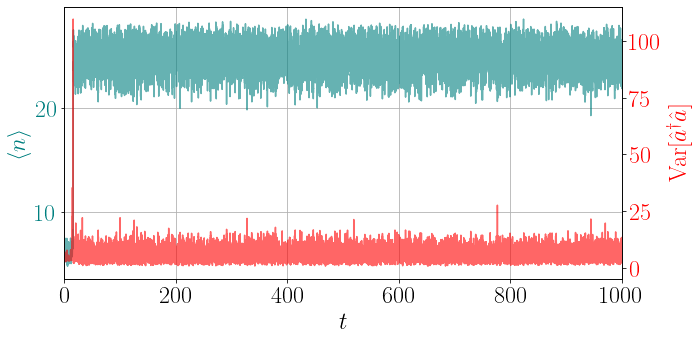

In [130]:
# nfilt = moving_average(e_t['n'], 500)
# n2filt = moving_average(e_t['n2'], 200)

fig, ax1 = plt.subplots(figsize=(10, 5))


fs = 24

c1 = [0., 0.5, 0.5]
c2 = [1, 0, 0]

color=c1
ax1.plot(t, e_t['n'], color=color ,label=r'$\langle x \rangle$', alpha=0.6)
ax1.set_xlabel(r'$t$', fontsize=fs)
ax1.set_ylabel(r'$\langle n \rangle$', color=color, fontsize=fs)
ax1.tick_params(axis='y', labelcolor=color, labelsize=fs)
ax1.tick_params(axis='x', labelsize=fs)
# plt.ylim([0, 10])

ax2 = ax1.twinx()

color2 = c2
ax2.plot(t, e_t['n2'] - e_t['n']**2, color=color2 ,label=r'$\langle x \rangle$', alpha=0.6)
ax2.set_ylabel(r'$\mathrm{Var}[\hat{a}^{\dagger}\hat{a}]$', color=color2, fontsize=fs)
ax2.tick_params(axis='y', labelcolor=color2, labelsize=fs)

plt.xlim([tm, tM])


ax1.grid(True)

plt.show()

counts = np.real(output.measurement[0].T[0])

In [131]:
scale = ts/tM
counts = np.real(output.measurement[0].T[0])/scale

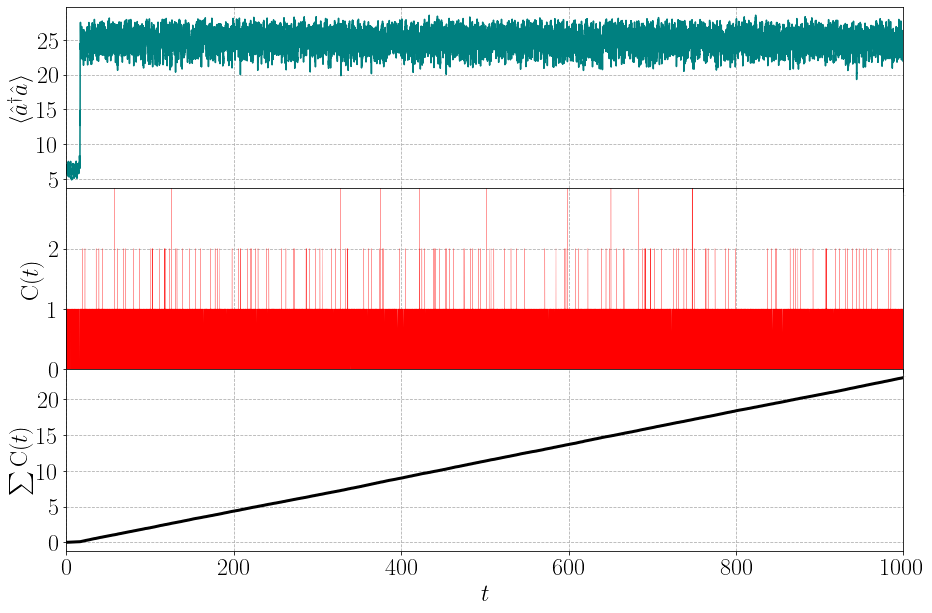

In [132]:

fig = plt.figure(figsize=(15,10))

plt.subplot(3, 1, 1)
plt.plot(t, e_t['n'], color=color ,label=r'$\langle \hat{a}^{\dagger}\hat{a} \rangle$', alpha=1)

plt.yticks(fontsize=fs)
plt.ylabel(r'$\langle \hat{a}^{\dagger}\hat{a} \rangle$', fontsize=fs)

plt.grid(True, linestyle='--')
plt.xlim([tm, tM])
plt.xticks(fontsize=0)


plt.subplot(3, 1, 2)
plt.plot(t, counts, color='r', linewidth=0.2, alpha=1)

plt.ylim([0, np.max(counts)])
plt.xlim([tm, tM])
plt.yticks([0, 1, 2], fontsize=fs)
plt.xticks(fontsize=0)
plt.ylabel(r'$\mathrm{C}(t)$', fontsize=fs)
plt.grid(True, linestyle='--')


plt.subplot(3, 1, 3)
plt.plot(t, np.cumsum(counts)/tM, color='k', linewidth=3)

plt.xlim([tm, tM])
plt.grid(True, linestyle='--')
plt.xlabel(r'$t$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$\sum \mathrm{C}(t)$', fontsize=fs)

plt.subplots_adjust(hspace = 0., wspace = 0.25)
plt.show()


# fig.savefig('counting.pdf',  dpi=500, bbox_inches='tight', pad_inches=0)

In [133]:
np.sum(counts)/tM

23.035769639999998

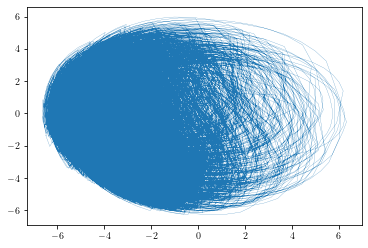

In [134]:
plt.plot(e_t['x'], e_t['p'], linewidth=0.2)

plt.show()

In [13]:
expect(n, rho0.eigenstates()[1][-2])

8.716898971100703

In [14]:
np.sum(e_t['n'])*dt/expect(n, rho0.eigenstates()[1][-2])

0.9204292355619722

# Repeat counting measurements for many trajectories and create histograms 

In [16]:
# Define parameters

na = 3
G = 1
U = 1/na
κ =  1
ϵ = 0*np.sqrt(na)
Δ = 2

In [17]:
N = 20
a = destroy(N)
n = num(N)
x = (a + a.dag())/np.sqrt(2)
p = -1j*(a - a.dag())/np.sqrt(2)
par = Parity(N)


H = -(G/2) * (a**2 + a.dag()**2) + (U/2)*a.dag()**2 * a**2 + 1j*ϵ*(a - a.dag()) - Δ*a.dag()*a
c_ops = [np.sqrt(κ)*a]
rho0 = steadystate(H, c_ops)
psi0 = rho0.eigenstates()[1][-3]

In [ ]:
# Define time parameters of the system
tm = 0
tM = 400
ts = 50000
t = np.linspace(tm, tM, ts)
dt = 1/(ts - 1)

# Dictionary of observables
e_dict = {'n': n,
         'x': x,
         'p': p,
         'n2': n**2,
         'x2': x**2,
         'par': par
         }
# Specify observables
e_ops = list(e_dict.values())

In [ ]:
sc_ops = [np.sqrt(κ)*a]
ntraj = 500   # Number of trajectories to average over
nsubsteps = 10

output = photocurrent_sesolve(H, psi0, t,   
                        sc_ops = c_ops,
                        ntraj=ntraj, 
                        e_ops = e_ops,
                        nsubsteps=nsubsteps, 
                        store_measurement=True
                     )

# Create dictionary of observables
e_t = {key: out for key, out in zip(e_dict, output.expect)}

In [ ]:
scale = ts/tM
counts = np.real(np.array(output.measurement).T[0].T)/scale

In [ ]:

for c in counts:
    plt.plot(t, np.cumsum(c), color='k', linewidth=1, alpha=0.5)

plt.xlim([tm, tM])
plt.grid(True, linestyle='--')
plt.xlabel(r'$t$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$\sum \mathrm{C}(t)$', fontsize=fs)

plt.subplots_adjust(hspace = 0., wspace = 0.25)
plt.show()


In [ ]:
plt.hist(np.cumsum(counts, axis=1)[:,-1], bins=5)
plt.show()


In [ ]:
plt.hist(np.random.normal(0, 1, 5000), bins=100)

plt.show()